In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH = '/content/drive/MyDrive/Прикладные задачи анализа данных/'

In [4]:
def load_image(directory, image_size=(256, 256)):
  train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
      directory, # путь к изображениям
      validation_split=0.2, # процент на тест
      subset="both", # берем и обучающую и тестовую выборку
      seed=42, # сид генератора случайных чисел
      image_size=image_size, # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
      batch_size=32, # размер пакета (батча)
  )
  return train_ds, test_ds

In [5]:
def predict(img_path, model, target_size):
  img = tf.keras.preprocessing.image.load_img(
      PATH+img_path, target_size=target_size
  )
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  plt.imshow(img)
  return model.predict(img_array)

# Часть 1

In [27]:
train_ds, test_ds = load_image(PATH+"data3", (200, 400))

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


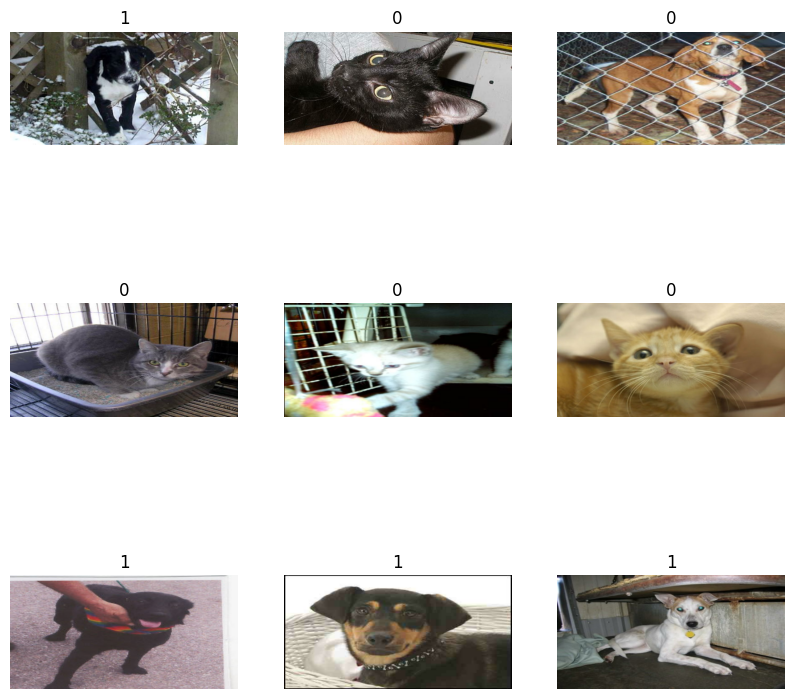

In [5]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [6]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

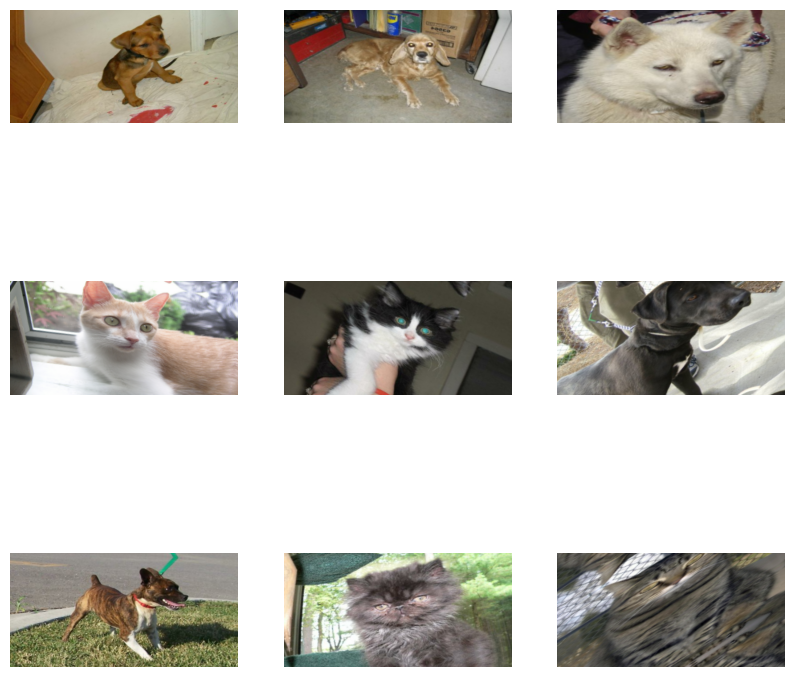

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
# выполним аугментации для обучающих данных предварительно (1 способ)
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

In [9]:
# входной слой - размер (200, 400, 3)
inputs = tf.keras.Input(shape=(200, 400, 3))
# преобразуем значения пикселей из [0, 255] к [0, 1]
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
# первый сверточный слой
x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same")(x)
# первый пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# второй сверточный слой
x = tf.keras.layers.Conv2D(128, 4, strides=2, padding="same")(x)
# второй пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# выпрямляем многомерный массив
x = tf.keras.layers.Flatten()(x)
# полносвязный слой с 64 нейронами
x = tf.keras.layers.Dense(64, activation="relu")(x)
# выходной слой с функцией sofrmax
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 400, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 200, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 100, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 50, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 25, 128)      0         
 2D)                                                         

In [11]:
# компилируем сеть, указываем, что будем при обучении смотреть значения accuracy
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [12]:
# начинаем обучение
# указываем validation_data - при обучении будем получать accuracy для тестовой выборки
model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
50/50 [==============================] - 189s 4s/step - loss: 1.1208 - accuracy: 0.5244 - val_loss: 0.6588 - val_accuracy: 0.5950
Epoch 2/5
50/50 [==============================] - 165s 3s/step - loss: 0.6613 - accuracy: 0.5987 - val_loss: 0.5857 - val_accuracy: 0.6725
Epoch 3/5
50/50 [==============================] - 160s 3s/step - loss: 0.6597 - accuracy: 0.6112 - val_loss: 0.6028 - val_accuracy: 0.6550
Epoch 4/5
50/50 [==============================] - 134s 3s/step - loss: 0.6375 - accuracy: 0.6425 - val_loss: 0.5576 - val_accuracy: 0.7450
Epoch 5/5
50/50 [==============================] - 130s 3s/step - loss: 0.6142 - accuracy: 0.6650 - val_loss: 0.5659 - val_accuracy: 0.7200


1/1 [==============================] - 0s 35ms/step
На картинке изображен: собака


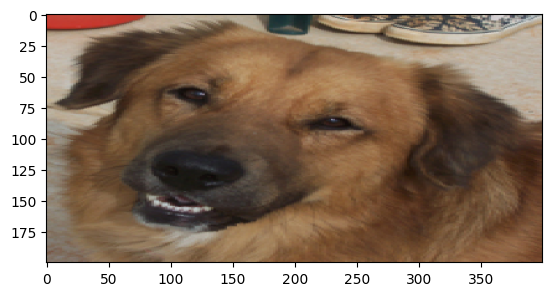

In [64]:
result = predict("data3/dogs/627.jpg", model, (200, 400))

print("На картинке изображен:", ['кошка', 'собака'][result.argmax()])

# Часть 2

### Загрузка изображений

In [30]:
train_ds, test_ds = load_image(PATH+"data2")

Found 170 files belonging to 3 classes.
Using 136 files for training.
Using 34 files for validation.


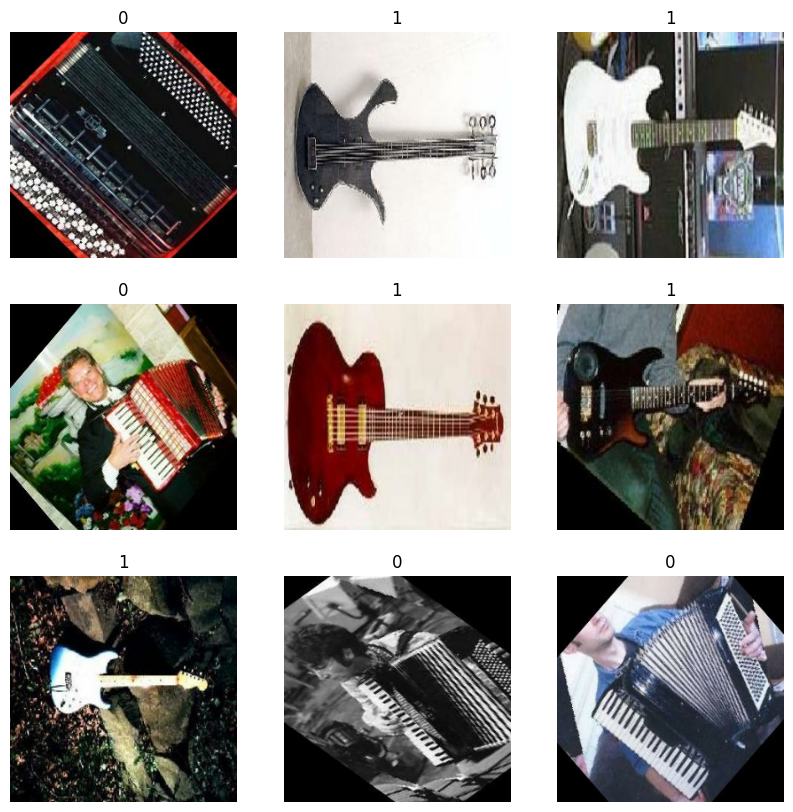

In [31]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

### InceptionV3

In [36]:
# загружаем предварительно обученную сеть InceptionV3
# параметр include_top со значением true указывает, что вместе со сверточными будут загружены
# полносвязные слои
incv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=True)
incv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_96[0][0]']              
 ormalization)                  )                                                      

In [37]:
# сохраним ссылку на входной слой сети
inp = incv3.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой InceptionV3 и наш новый слой классификации
out = new_classification_layer(incv3.layers[-2].output)

# создадим новую модель
model_new = tf.keras.Model(inp, out)

In [38]:
# посмотрим, что изменилось
model_new.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_96[0][0]']              
 ormalization)                  )                                                           

In [39]:
# "заморозим" все слои, кроме последнего
for layer in model_new.layers:
    layer.trainable = False
model_new.layers[-1].trainable = True

In [40]:
model_new.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_96[0][0]']              
 ormalization)                  )                                                           

In [41]:
train_ds, test_ds = load_image(PATH+"data2", (299, 299))

Found 170 files belonging to 3 classes.
Using 136 files for training.
Using 34 files for validation.


In [42]:
model_new.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
5/5 [==============================] - 49s 9s/step - loss: 15.6635 - accuracy: 0.3897 - val_loss: 21.6835 - val_accuracy: 0.2353
Epoch 2/5
5/5 [==============================] - 39s 8s/step - loss: 15.0807 - accuracy: 0.3750 - val_loss: 3.1391 - val_accuracy: 0.7353
Epoch 3/5
5/5 [==============================] - 47s 10s/step - loss: 4.6915 - accuracy: 0.5294 - val_loss: 4.2788 - val_accuracy: 0.6765
Epoch 4/5
5/5 [==============================] - 41s 8s/step - loss: 4.9675 - accuracy: 0.5588 - val_loss: 2.8195 - val_accuracy: 0.7059
Epoch 5/5
5/5 [==============================] - 37s 8s/step - loss: 2.4448 - accuracy: 0.6838 - val_loss: 3.8407 - val_accuracy: 0.6176


1/1 [==============================] - 0s 228ms/step
На картинке изображен: саксофон


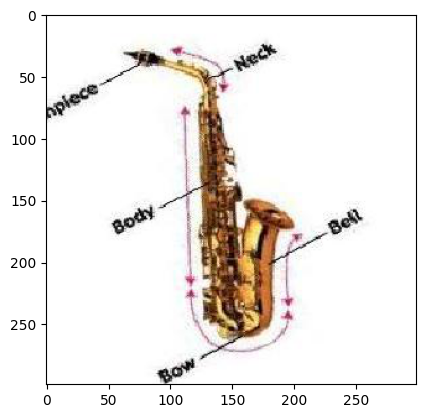

In [65]:
result = predict("data2/saxophone/image_0027.jpg", model_new, (299, 299))

print("На картинке изображен:", 
 ['аккордеон', 'электрогитара', 'саксофон'][result.argmax()])

### VGG19

In [6]:
# загружаем предварительно обученную сеть VGG19
# параметр include_top со значением true указывает, что вместе со сверточными будут загружены
# полносвязные слои
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=True)
vgg.summary()

574710816/574710816 [==============================] - 22s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [7]:
# сохраним ссылку на входной слой сети
inp = vgg.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой VGG и наш новый слой классификации
out = new_classification_layer(vgg.layers[-2].output)

# создадим новую модель
model_new2 = tf.keras.Model(inp, out)

In [8]:
# посмотрим, что изменилось
model_new2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
# "заморозим" все слои, кроме последнего
for layer in model_new2.layers:
    layer.trainable = False
model_new2.layers[-1].trainable = True

In [11]:
model_new2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
train_ds, test_ds = load_image(PATH+"data2", (224, 224))

Found 170 files belonging to 3 classes.
Using 136 files for training.
Using 34 files for validation.


In [13]:
model_new2.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
5/5 [==============================] - 198s 32s/step - loss: 1.0714 - accuracy: 0.5735 - val_loss: 0.0718 - val_accuracy: 1.0000
Epoch 2/5
5/5 [==============================] - 148s 30s/step - loss: 0.0697 - accuracy: 0.9853 - val_loss: 0.0218 - val_accuracy: 1.0000
Epoch 3/5
5/5 [==============================] - 153s 31s/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 4/5
5/5 [==============================] - 148s 30s/step - loss: 0.0079 - accuracy: 0.9926 - val_loss: 0.0195 - val_accuracy: 1.0000
Epoch 5/5
5/5 [==============================] - 135s 27s/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 1.0000


1/1 [==============================] - 2s 2s/step
На картинке изображен: аккордеон


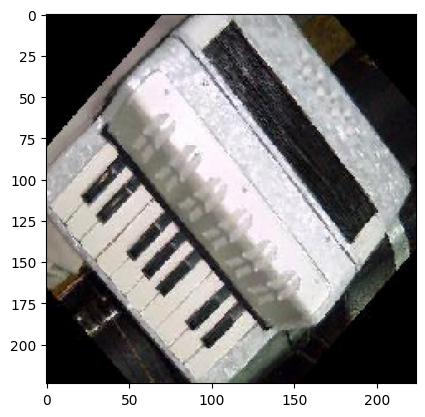

In [18]:
result = predict("data2/accordion/image_0023.jpg", model_new2, target_size=(224, 224))

print("На картинке изображен:", 
 ['аккордеон', 'электрогитара', 'саксофон'][result.argmax()])